In [2]:
import jupyterthemes as jt

In [15]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [18]:
!jt -t onedork

# Building the Model

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import cv2

In [4]:
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'Dataset/Train'
validation_data_dir = 'Dataset/Test'
# number of epochs to train top model
epochs = 20
# batch size used by flow_from_directory and predict_generator
batch_size = 32

In [5]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict(
        generator, predict_size_train)

    np.save('./Models/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict(
        generator, predict_size_validation)

    np.save('./Models/bottleneck_features_validation.npy',
            bottleneck_features_validation)


In [6]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('./Models/class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('./Models/bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('./Models/bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [7]:
def predict():
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('./Models/class_indices.npy', allow_pickle=True).item()

    num_classes = len(class_dictionary)

    # add the path to your test image below
    image_path = 'Dataset/Test_new/Steel/65.jpg'

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

    # display the predictions with the image
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [8]:
save_bottlebeck_features()

Found 5173 images belonging to 6 classes.
5173
{'Airplane': 0, 'Candle': 1, 'Christmas_Tree': 2, 'Jacket': 3, 'Miscellaneous': 4, 'Snowman': 5}
6
Found 1296 images belonging to 6 classes.


Found 5173 images belonging to 6 classes.
Found 1296 images belonging to 6 classes.
Epoch 1/20
162/162 [==============================] - 26s 161ms/step - loss: 6.2874 - accuracy: 0.4449 - val_loss: 0.7827 - val_accuracy: 0.7160
Epoch 2/20
162/162 [==============================] - 25s 157ms/step - loss: 0.8464 - accuracy: 0.6979 - val_loss: 0.8940 - val_accuracy: 0.7037
Epoch 3/20
162/162 [==============================] - 26s 158ms/step - loss: 0.6159 - accuracy: 0.7710 - val_loss: 0.7422 - val_accuracy: 0.7346
Epoch 4/20
162/162 [==============================] - 25s 157ms/step - loss: 0.5215 - accuracy: 0.8067 - val_loss: 1.4069 - val_accuracy: 0.5694
Epoch 5/20
162/162 [==============================] - 25s 157ms/step - loss: 0.4354 - accuracy: 0.8413 - val_loss: 1.1211 - val_accuracy: 0.6528
Epoch 6/20
162/162 [==============================] - 25s 157ms/step - loss: 0.3552 - accuracy: 0.8647 - val_loss: 0.9514 - val_accuracy: 0.7461
Epoch 7/20
162/162 [==========================

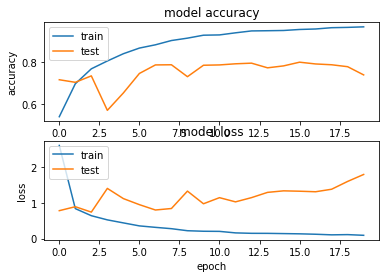

In [9]:
train_top_model()

In [8]:
predict()

[INFO] loading and preprocessing image...


C:\Users\adih4\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\adih4\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Image ID: 0, Label: Adhered


In [ ]:
cv2.destroyAllWindows()

In [10]:
import os
from glob import glob

In [11]:
def predict(file):
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('./Models/class_indices.npy', allow_pickle=True).item()

    num_classes = len(class_dictionary)

    # add the path to your test image below
    image_path = file

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    #print("Image ID: {}, Label: {}".format(inID, label))
    return label

    # display the predictions with the image
#     cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
#                 cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

#     cv2.imshow("Classification", orig)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()


In [21]:
('image7.jpg', predict('./test/image7.jpg'))

[INFO] loading and preprocessing image...


('image7.jpg', 'Christmas_Tree')

In [22]:
arr = []
for i in os.listdir('./test'):
    arr.append([i, predict('./test/{}'.format(i))])

[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


[INFO] loading and preprocessing image...
[INFO] loading and preprocessing image...


In [23]:
arr

[['image10.jpg', 'Miscellaneous'],
 ['image100.jpg', 'Airplane'],
 ['image1013.jpg', 'Jacket'],
 ['image1014.jpg', 'Miscellaneous'],
 ['image1018.jpg', 'Christmas_Tree'],
 ['image1019.jpg', 'Miscellaneous'],
 ['image1021.jpg', 'Jacket'],
 ['image1023.jpg', 'Miscellaneous'],
 ['image1024.jpg', 'Miscellaneous'],
 ['image1029.jpg', 'Christmas_Tree'],
 ['image1030.jpg', 'Airplane'],
 ['image1031.jpg', 'Christmas_Tree'],
 ['image1032.jpg', 'Miscellaneous'],
 ['image1034.jpg', 'Christmas_Tree'],
 ['image1035.jpg', 'Jacket'],
 ['image1040.jpg', 'Jacket'],
 ['image1042.jpg', 'Jacket'],
 ['image1043.jpg', 'Miscellaneous'],
 ['image1045.jpg', 'Miscellaneous'],
 ['image1048.jpg', 'Candle'],
 ['image1049.jpg', 'Miscellaneous'],
 ['image105.jpg', 'Airplane'],
 ['image1051.jpg', 'Miscellaneous'],
 ['image1052.jpg', 'Airplane'],
 ['image1055.jpg', 'Jacket'],
 ['image1058.jpg', 'Miscellaneous'],
 ['image1059.jpg', 'Snowman'],
 ['image1061.jpg', 'Candle'],
 ['image1062.jpg', 'Jacket'],
 ['image1063.jpg

In [24]:
import pandas as pd
df = pd.DataFrame(arr)

In [25]:
df.head()

0               1
0    image10.jpg   Miscellaneous
1   image100.jpg        Airplane
2  image1013.jpg          Jacket
3  image1014.jpg   Miscellaneous
4  image1018.jpg  Christmas_Tree

In [26]:
df.columns = ['Image', 'Class']

In [27]:
df.set_index('Image', inplace=True)

In [28]:
df.head()

Class
Image                        
image10.jpg     Miscellaneous
image100.jpg         Airplane
image1013.jpg          Jacket
image1014.jpg   Miscellaneous
image1018.jpg  Christmas_Tree

In [29]:
df.to_csv('results.csv')